In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
import warnings
from random import randint
from sklearn.model_selection import StratifiedKFold

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Models/GDSC_PDX_TCGA_First_Strategy/"
finetuned_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Models/GDSC_PDX_TCGA_First_Strategy/First_Strategy_Finetuned_Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
pathfindR_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/pathfindR/GDSC_PDX_TCGA_First_Strategy/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
gemcitabine_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi/gemcitabine/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation_CNA/Predictions/GDSC_PDX_TCGA_First_Strategy/"
ec_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_CNA/Predictions/GDSC_PDX_TCGA_First_Strategy/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_First_Strategy/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Figures/GDSC_PDX_TCGA_First_Strategy/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent
,TOTAL:,1001,996,968,957,990,,,,,,


In [6]:
# change directory to read GDSC expression dataset (DNA_REPi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (DNA_REPi)

GDSCE = pd.read_csv("GDSC_exprs.z.DNA_REPi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
684055,1.3565140948247052,-0.277542411913307,0.0887087882196536,-0.2754829982302413,-0.5153856346587746,-0.6248712076433911,0.1243408990866293,-1.2699667684674136,2.0788360886382717,2.5197991997459197,...,-0.5571028630154293,-1.724090733574364,-0.3749080365068901,-0.0016055431935905,-0.3788535663547365,-1.3502092798315848,0.6949790577550328,0.4333032198982747,-0.1280986270308099,-1.629249958712223
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [8]:
# change directory to read GDSC mutation dataset (DNA_REPi)

os.chdir(dataset_dir + "/mutations/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations


In [9]:
# read GDSC mutation dataset (DNA_REPi)

GDSCM = pd.read_csv("GDSC_mutations.DNA_REPi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCM.drop_duplicates(keep='last')
GDSCM = pd.DataFrame.transpose(GDSCM)
GDSCM = GDSCM.loc[:, ~GDSCM.columns.duplicated()]

GDSCM.head()

,143872,728577,2,2050,10243,79365,256006,4609,118788,113675,...,26517,28972,53917,283507,514,339210,64981,7335,5739,83442
683665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# change directory to read GDSC response dataset (DNA_REPi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [11]:
# read GDSC response dataset (DNA_REPi)

GDSCR = pd.read_csv("GDSC_response.DNA_REPi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,5.12075503641523,Pyrimethamine,1,1,1
683665,0,-3.03711635474651,Doxorubicin,1,1,1
683665,0,-0.712119156515401,Etoposide,1,1,1
683665,0,-4.40897202584936,Gemcitabine,1,1,1
683665,0,-1.59752443691324,Mitomycin C,1,1,1


In [12]:
# print count of cell lines for each drug (DNA_REPi)

GDSCR["drug"].value_counts()

drug
Etoposide         775
SN-38             771
Mitomycin C       767
Doxorubicin       766
5-Fluorouracil    764
Gemcitabine       761
Bleomycin         759
Temozolomide      752
Cisplatin         738
Methotrexate      738
Camptothecin      737
Cytarabine        735
Pyrimethamine     372
Name: count, dtype: int64

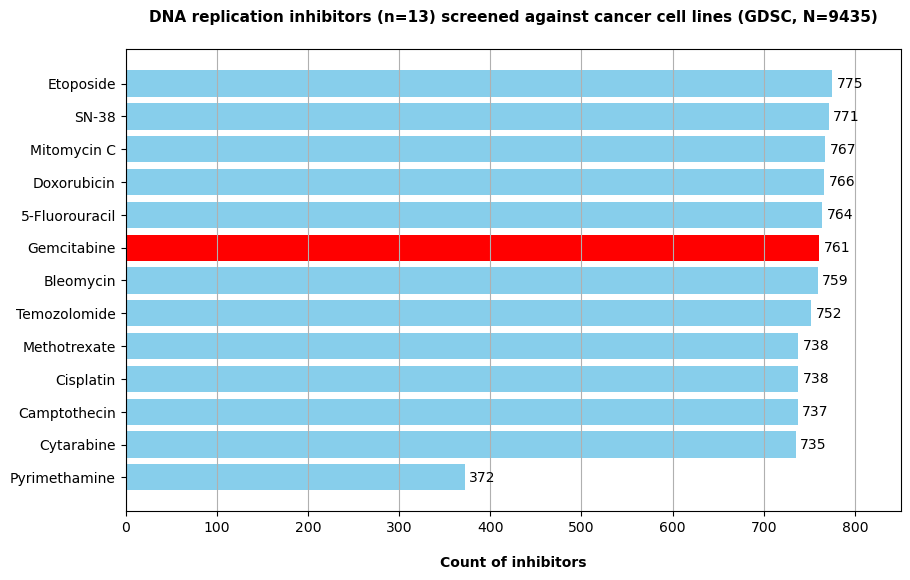

In [13]:
gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Gemcitabine":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'DNA replication inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'DNA Replication Inhibitors with Their Counts (GDSC, Gemcitabine).png', format='png', bbox_inches='tight')

plt.show()

In [14]:
# change directory to read PDX and TCGA expression datasets homogenized with GDSC expression dataset (Gemcitabine)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [15]:
# read PDX expression dataset homogenized with GDSC expression dataset (Gemcitabine)

PDXEgemcitabine = pd.read_csv("PDX_exprs.Gemcitabine.eb_with.GDSC_exprs.Gemcitabine.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEgemcitabine = pd.DataFrame.transpose(PDXEgemcitabine)
PDXEgemcitabine.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1199,4.01417756220044,3.55811958088587,6.83900390800765,4.38877376417435,1.50666127948843,5.02771257808434,8.43955592164473,2.85208997496268,9.00048066769525,5.52248167850218,...,2.83437923324963,3.18066968142204,6.86894950827138,3.09303561080421,3.06056009765469,3.25550719551845,2.66209753115624,4.89535625008263,0,2.53286170515559
X-1289,3.81163538029984,3.55811958088587,7.32657832557435,4.60329219527869,2.70668525625435,3.94530321859601,8.38639293838613,3.16570624417349,8.80528687662163,4.02249343941382,...,2.78756471299352,3.18066968142204,6.45652489684015,3.09303561080421,3.06056009765469,2.55755763454488,2.66209753115624,4.66362817768075,0,2.92817140721819
X-1317,6.56141894155303,9.93900865308036,5.9645748758066,2.89206965997821,4.24925937434505,2.43002821482342,8.19585380485642,3.24884065836222,9.13531900723866,3.39900580748116,...,2.84342078648607,4.76280820040358,6.724116861893,3.09303561080421,3.06056009765469,2.55755763454488,4.01252295145878,3.28462638352963,0,4.63700409301447


In [16]:
# read TCGA expression dataset homogenized with GDSC expression dataset (Gemcitabine)

TCGAEgemcitabine = pd.read_csv("TCGA_exprs.Gemcitabine.eb_with.GDSC_exprs.Gemcitabine.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEgemcitabine = pd.DataFrame.transpose(TCGAEgemcitabine)
TCGAEgemcitabine.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-2L-AAQA-01A,3.98033768533371,2.62820652008909,7.03249429468481,3.08514834183615,3.34557990074588,3.78552975984518,8.73764964752829,2.48671779353536,8.21923206815042,3.76684655565602,...,10.0875725194276,2.81337967290836,3.51332685491118,3.98785715416424,3.07567558045391,2.56126348424232,2.63693987323012,2.83133300992887,5.13739151604047,4.69382514336529
TCGA-2L-AAQE-01A,4.68614471637408,3.25092419132046,5.75542155466148,2.79866479035723,1.96329083991897,3.43063349827168,8.80671304478463,2.62779485919227,8.54483025692787,3.81532940417382,...,8.87561409312678,2.81337967290836,2.78991865702044,3.30688425304558,3.45865630140412,2.53490145426966,2.74899279856495,2.83133300992887,4.61757632178081,4.2235154535305
TCGA-2L-AAQI-01A,3.71023111103364,3.88843437623036,5.77580575110606,3.10749843796475,5.98690471000489,3.75736553725429,8.4255369043372,2.48671779353536,9.21052968908206,3.97685914269242,...,9.48642956588486,2.84555917176674,2.78991865702044,3.48989111572046,2.79620231354257,2.49624245190844,2.630937590025,2.83133300992887,4.38859435268046,3.64555981820771


In [17]:
# change directory to read PDX mutation dataset (Gemcitabine)

os.chdir(dataset_dir + "mutations")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations'

In [18]:
# read PDX mutation dataset (Gemcitabine)

PDXMgemcitabine = pd.read_csv("PDX_mutations.Gemcitabine.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXMgemcitabine.drop_duplicates(keep='last')
PDXMgemcitabine = pd.DataFrame.transpose(PDXMgemcitabine)
PDXMgemcitabine = PDXMgemcitabine.loc[:, ~PDXMgemcitabine.columns.duplicated()]

PDXMgemcitabine.head(3)

ENTREZID,3075.0,171017.0,2058.0,79890.0,7701.0,3104.0,4642.0,9778.0,100132406.0,23607.0,...,253738.0,154807.0,79140.0,6307.0,6352.0,56005.0,115650.0,64946.0,5777.0,253639.0
X-1199,0.0,0.0,0.0,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1289,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1317,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,0.0,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# read TCGA mutation dataset (Gemcitabine)

TCGAMgemcitabine = pd.read_csv("TCGA_mutations.Gemcitabine.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGAMgemcitabine.drop_duplicates(keep='last')
TCGAMgemcitabine = pd.DataFrame.transpose(TCGAMgemcitabine)
TCGAMgemcitabine = TCGAMgemcitabine.loc[:, ~TCGAMgemcitabine.columns.duplicated()]

TCGAMgemcitabine.head(3)

,10946,23301,26470,340075,2059,26286,2034,348980,406,653240,...,6176,91948,9403,113402,8637,389124,277,83460,51021,1052
TCGA-2L-AAQA-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,0.0,-0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-2L-AAQE-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-2L-AAQI-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# variance threshold for GDSC expression dataset (DNA_REPi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [21]:
# fill NA values and binarize GDSC mutation dataset (DNA_REPi)

GDSCM = GDSCM.fillna(0)
GDSCM[GDSCM != 0.0] = 1

In [22]:
# select shared genes between GDSC, PDX, and TCGA expression and mutation datasets 

ls = GDSCE.columns.intersection(GDSCM.columns)
ls = ls.intersection(PDXEgemcitabine.columns)
ls = ls.intersection(PDXMgemcitabine.columns)
ls = ls.intersection(TCGAEgemcitabine.columns)
ls = ls.intersection(TCGAMgemcitabine.columns)

ls = pd.unique(ls)

print(f"GDSC, PDX & TCGA # of common genes: {ls.shape[0]}")

GDSC, PDX & TCGA # of common genes: 13831


In [23]:
# select shared samples between GDSC expression, mutation, and response datasets (DNA_REPi)

ls2 = GDSCE.index.intersection(GDSCM.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 801


In [24]:
# subset shared genes and samples in GDSC expression, mutation, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCM = GDSCM.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCM.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

GDSC # of common samples and genes (Expression): (801, 13831)
GDSC # of common samples and genes (Mutation): (801, 13831)
GDSC # of samples (Response): 9435


In [25]:
# select shared samples between PDX expression and mutation datasets (Gemcitabine) 

ls3 = PDXEgemcitabine.index.intersection(PDXMgemcitabine.index)

print(f"PDX # of common samples (Gemcitabine): {ls3.shape[0]}")

PDX # of common samples (Gemcitabine): 25


In [26]:
# select shared samples between TCGA expression and mutation datasets (Gemcitabine) 

ls4 = TCGAEgemcitabine.index.intersection(TCGAMgemcitabine.index)

print(f"TCGA # of common samples (Gemcitabine): {ls4.shape[0]}")

TCGA # of common samples (Gemcitabine): 55


In [27]:
# select shared genes and samples between PDX and TCGA expression and mutation datasets (Gemcitabine)

PDXEgemcitabine = PDXEgemcitabine.loc[ls3, ls]
PDXMgemcitabine = PDXMgemcitabine.loc[ls3, ls]

TCGAEgemcitabine = TCGAEgemcitabine.loc[ls4, ls]
TCGAMgemcitabine = TCGAMgemcitabine.loc[ls4, ls]

print(f"PDX # of common samples and genes for Expression (Gemcitabine): {PDXEgemcitabine.shape}")
print(f"PDX # of common samples and genes for Mutation (Gemcitabine): {PDXMgemcitabine.shape}\n")

print(f"TCGA # of common samples and genes for Expression (Gemcitabine): {TCGAEgemcitabine.shape}")
print(f"TCGA # of common samples and genes for Mutation (Gemcitabine): {TCGAMgemcitabine.shape}")

PDX # of common samples and genes for Expression (Gemcitabine): (25, 13831)
PDX # of common samples and genes for Mutation (Gemcitabine): (25, 13831)

TCGA # of common samples and genes for Expression (Gemcitabine): (55, 13831)
TCGA # of common samples and genes for Mutation (Gemcitabine): (55, 13831)


In [28]:
# change directory to read DEGs (DNA_REPi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi


In [29]:
# read DEGs (DNA_REPi)

DEGs_filtered_data = pd.read_excel("DNA_REPi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among DNA replication inhibitors\n")

DEGs_filtered_data.head()

There are 858 DEGs (p-adjusted < 0.05 and |logFC| > 1) among DNA replication inhibitors



,Gene Symbol,Frequency
0,SLFN11,9
1,NCKAP1L,8
2,SDC4,7
3,KRT18,7
4,S100A14,7


In [30]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id.dropna(inplace=True)

DEGs_entrez_id.shape[0]

1 input query terms found dup hits:	[('CLECL1P', 2)]


858

In [31]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
mut = GDSCM
responses = GDSCR

In [32]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,5.12075503641523,Pyrimethamine,1,1,1
683665,0,-3.03711635474651,Doxorubicin,1,1,1
683665,0,-0.712119156515401,Etoposide,1,1,1


In [33]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'5-Fluorouracil',
 'Bleomycin',
 'Camptothecin',
 'Cisplatin',
 'Cytarabine',
 'Doxorubicin',
 'Etoposide',
 'Gemcitabine',
 'Methotrexate',
 'Mitomycin C',
 'Pyrimethamine',
 'SN-38',
 'Temozolomide'}

In [34]:
# convert Entrez gene IDs to integer

responses.index = responses.index.astype(int)
responses.index

Index([ 683665,  683665,  683665,  683665,  683665,  683665,  683665,  683665,
        683665,  683665,
       ...
       1659818, 1659818, 1659818, 1659818, 1659819, 1659819, 1659819, 1659819,
       1659819,  687800],
      dtype='int64', length=9435)

In [35]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
#dat.head()

GDSC\nTissue descriptor 1
lung_NSCLC           1037
urogenital_system     926
leukemia              829
lymphoma              769
aero_dig_tract        727
nervous_system        607
lung_SCLC             569
skin                  560
breast                524
digestive_system      466
large_intestine       447
bone                  421
neuroblastoma         332
pancreas              294
kidney                227
soft_tissue           191
myeloma               182
lung                  174
thyroid               153
Name: count, dtype: int64

In [36]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    639
lung_small_cell_carcinoma    569
glioma                       558
breast                       524
melanoma                     522
Name: count, dtype: int64

In [37]:
# assign tissue descriptors to variable

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_names

['lung_NSCLC',
 'urogenital_system',
 'leukemia',
 'lymphoma',
 'aero_dig_tract',
 'nervous_system',
 'lung_SCLC',
 'skin',
 'breast',
 'digestive_system',
 'large_intestine',
 'bone',
 'neuroblastoma',
 'pancreas',
 'kidney',
 'soft_tissue',
 'myeloma',
 'lung',
 'thyroid']

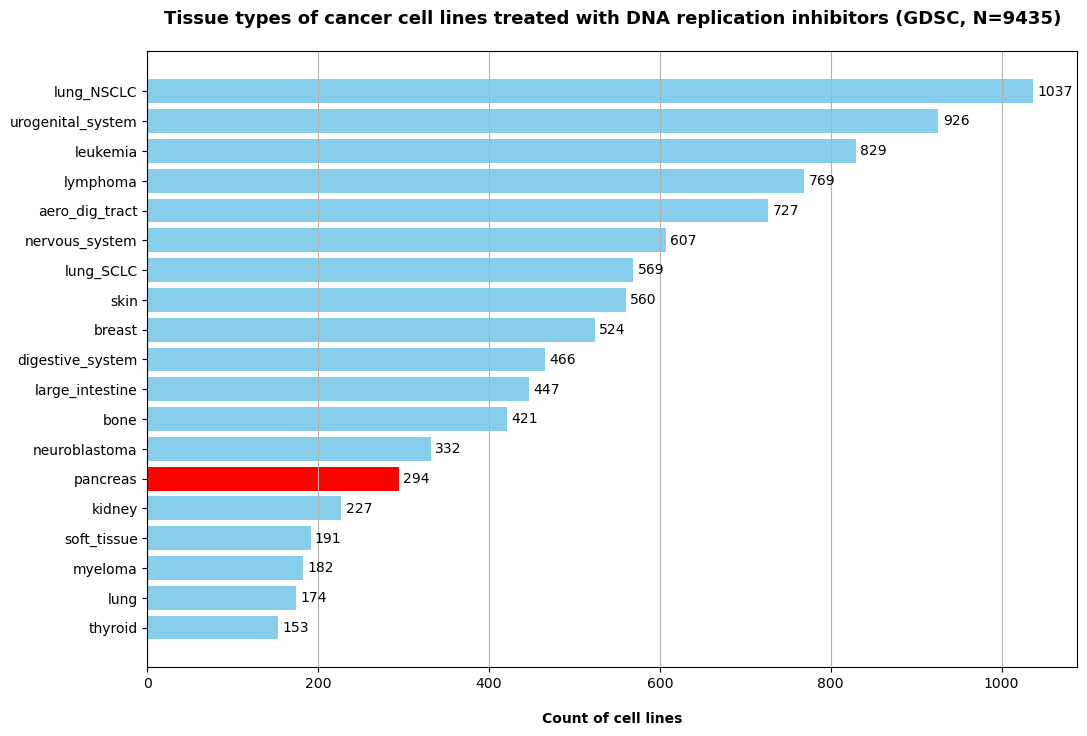

In [38]:
# plot tissue types of cancer cell lines treated with EGFR signaling inhibitors

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with DNA replication inhibitors (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "pancreas":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with DNA replication inhibitors (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [39]:
# list count of cell lines as to tissues treated with gemcitabine

filter = (dat["drug"] == "Gemcitabine")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
lung_NSCLC           86
urogenital_system    76
leukemia             64
aero_dig_tract       62
lymphoma             59
nervous_system       47
skin                 47
lung_SCLC            46
breast               43
digestive_system     38
large_intestine      35
bone                 34
neuroblastoma        25
pancreas             25
kidney               17
soft_tissue          16
lung                 15
myeloma              13
thyroid              13
Name: count, dtype: int64

In [40]:
# list count of cell lines as to tissues treated with gemcitabine

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "Gemcitabine")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    53
lung_small_cell_carcinoma    46
melanoma                     44
breast                       43
glioma                       43
Name: count, dtype: int64

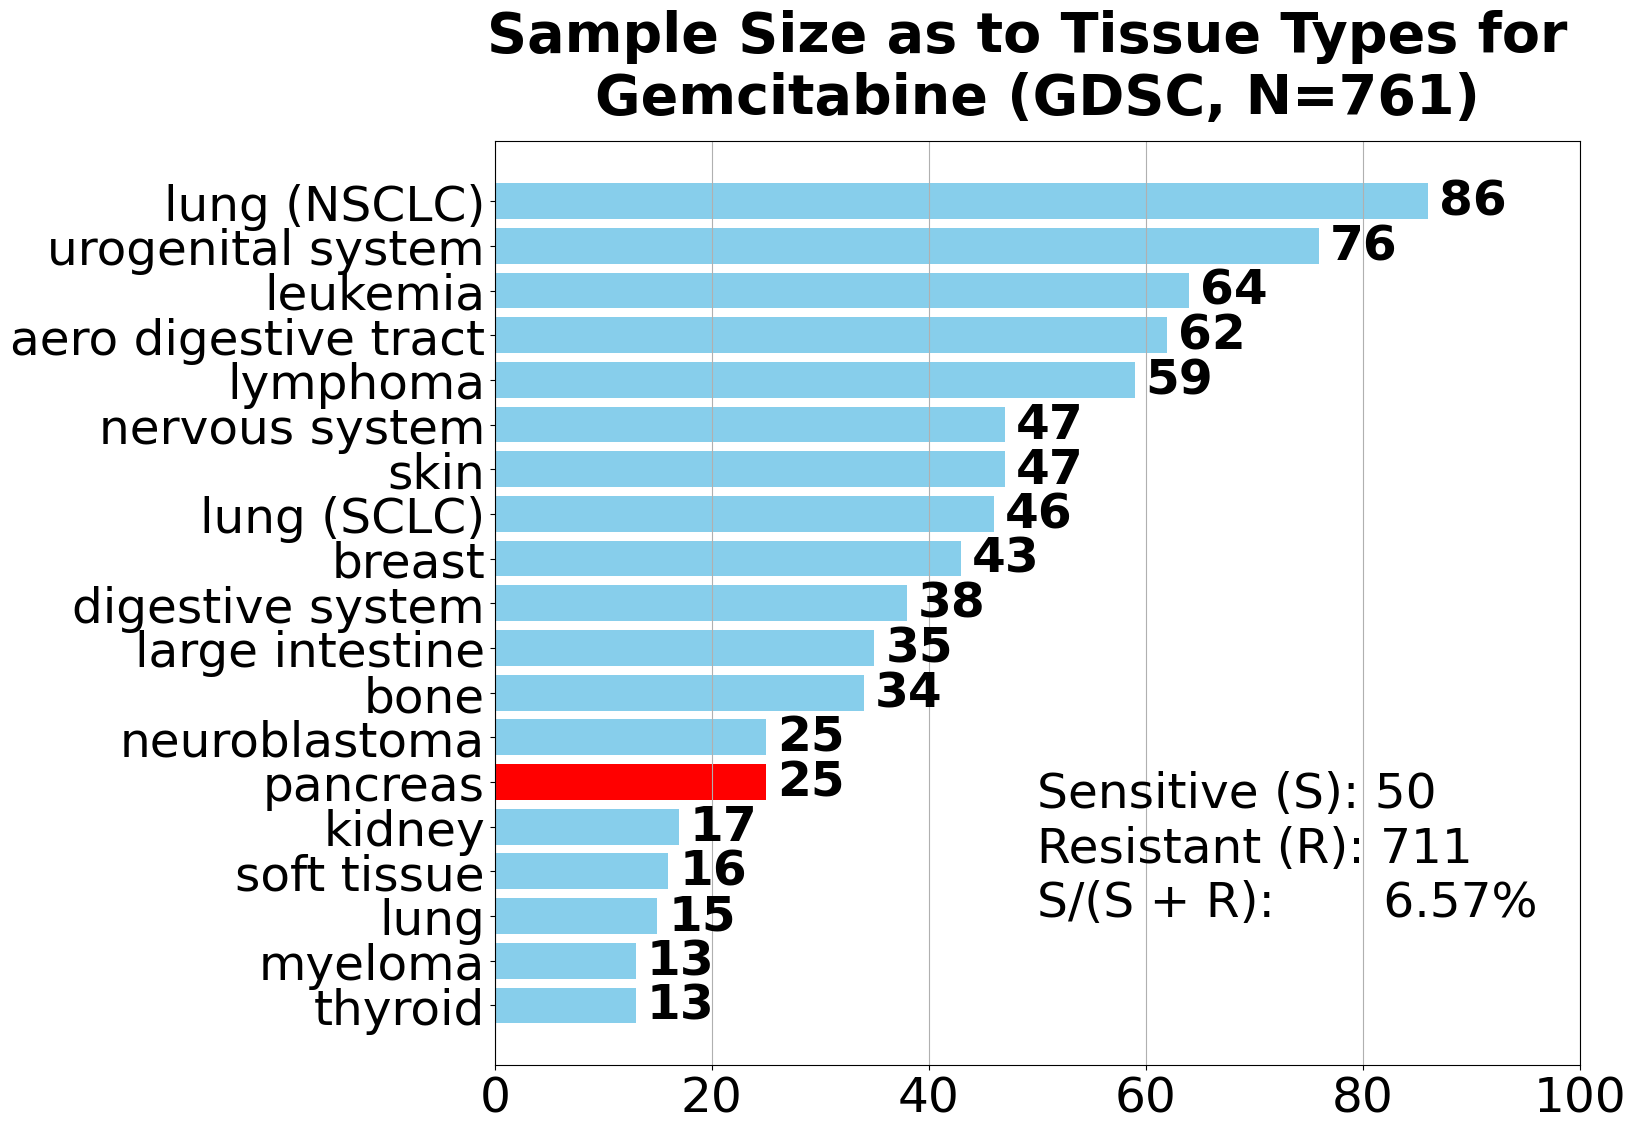

In [41]:
gdsc_tissue_counts =  tissues_drugs.loc[filter, 'GDSC\nTissue descriptor 1'].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_names = ["lung (NSCLC)", "urogenital system", "leukemia", "aero digestive tract", "lymphoma", 
                    "nervous system", "skin", "lung (SCLC)", "breast",  "digestive system","large intestine",
                    "bone", "neuroblastoma", "pancreas",
                    "kidney",  "soft tissue", "lung", "myeloma", "thyroid"]
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(14, 12))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel(None)
plt.title(f'Sample Size as to Tissue Types for \nGemcitabine (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=40,
           pad=20)
plt.gca().invert_yaxis() 
plt.xlim(0, 100)
plt.grid(axis='x')
plt.tick_params(axis='y', labelsize=35)
plt.tick_params(axis='x', labelsize=35)

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 1, bar.get_y() + bar.get_height()/2, str(value), va='center', fontsize = 35, fontweight = "bold")

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "pancreas":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(50, 16, 
         f'Sensitive (S): {dat.loc[dat["drug"] == "Gemcitabine", "response"].value_counts()[1]} \nResistant (R): {dat.loc[dat["drug"] == "Gemcitabine", "response"].value_counts()[0]} \nS/(S + R):       {round(dat.loc[dat["drug"] == "Gemcitabine", "response"].value_counts()[1]/(sum(dat.loc[dat["drug"] == "Gemcitabine", "response"].value_counts())) * 100, 2)}%', 
         fontsize=35, 
         color='black')

plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with Gemcitabine (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [42]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683665',
       ...
       '1659818', '1659818', '1659818', '1659818', '1659819', '1659819',
       '1659819', '1659819', '1659819', '687800'],
      dtype='object', length=9435)

In [43]:
# filter GDSC expression and mutation datasets (DNA_REPi) as to drugs
# subset selected DEGs

expression_zscores = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    m = mut.loc[samples, :]
    expression_zscores.append(e_z)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCMv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCMv2 = GDSCMv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEgemcitabine = PDXEgemcitabine.loc[:,ls5]
PDXMgemcitabine = PDXMgemcitabine.loc[:,ls5]
TCGAEgemcitabine = TCGAEgemcitabine.loc[:,ls5]
TCGAMgemcitabine = TCGAMgemcitabine.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Gemcitabine (Expression): {PDXEgemcitabine.shape}")
print(f"PDX # of common samples and genes for Gemcitabine (Mutation): {PDXMgemcitabine.shape}\n")

print(f"TCGA # of common samples and genes for Gemcitabine (Expression): {TCGAEgemcitabine.shape}")
print(f"TCGA # of common samples and genes for Gemcitabine (Mutation): {TCGAMgemcitabine.shape}")

GDSC # of common samples and genes (Expression): (9435, 710)
GDSC # of common samples and genes (Mutation): (9435, 710)
GDSC # of common samples (Response): 9435

PDX # of common samples and genes for Gemcitabine (Expression): (25, 710)
PDX # of common samples and genes for Gemcitabine (Mutation): (25, 710)

TCGA # of common samples and genes for Gemcitabine (Expression): (55, 710)
TCGA # of common samples and genes for Gemcitabine (Mutation): (55, 710)


In [44]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 0 1 0]


In [45]:
# change directory to read PDX and TCGA response datasets (Gemcitabine)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [46]:
# read PDX response dataset (Gemcitabine)

PDXRgemcitabine = pd.read_csv("PDX_response.Gemcitabine.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRgemcitabine.dropna(inplace=True)
PDXRgemcitabine.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRgemcitabine["response"] = PDXRgemcitabine.loc[:, "response"].apply(lambda x: d[x])
Ytsgemcitabine_pdx = PDXRgemcitabine["response"].values    

print(f"There are {Ytsgemcitabine_pdx.shape[0]} samples with response data in the PDX (Gemcitabine)\n")
Ytsgemcitabine_pdx

There are 25 samples with response data in the PDX (Gemcitabine)



array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1])

In [47]:
# read PDX dataset to select cohorts (Gemcitabine)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "gemcitabine-50mpk",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-0991,PDAC
X-1199,PDAC
X-1289,PDAC
X-1317,PDAC
X-1362,PDAC


In [48]:
# merged PDX cohort table with PDX response dataset (Gemcitabine)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRgemcitabine,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
PDAC    25
Name: count, dtype: int64

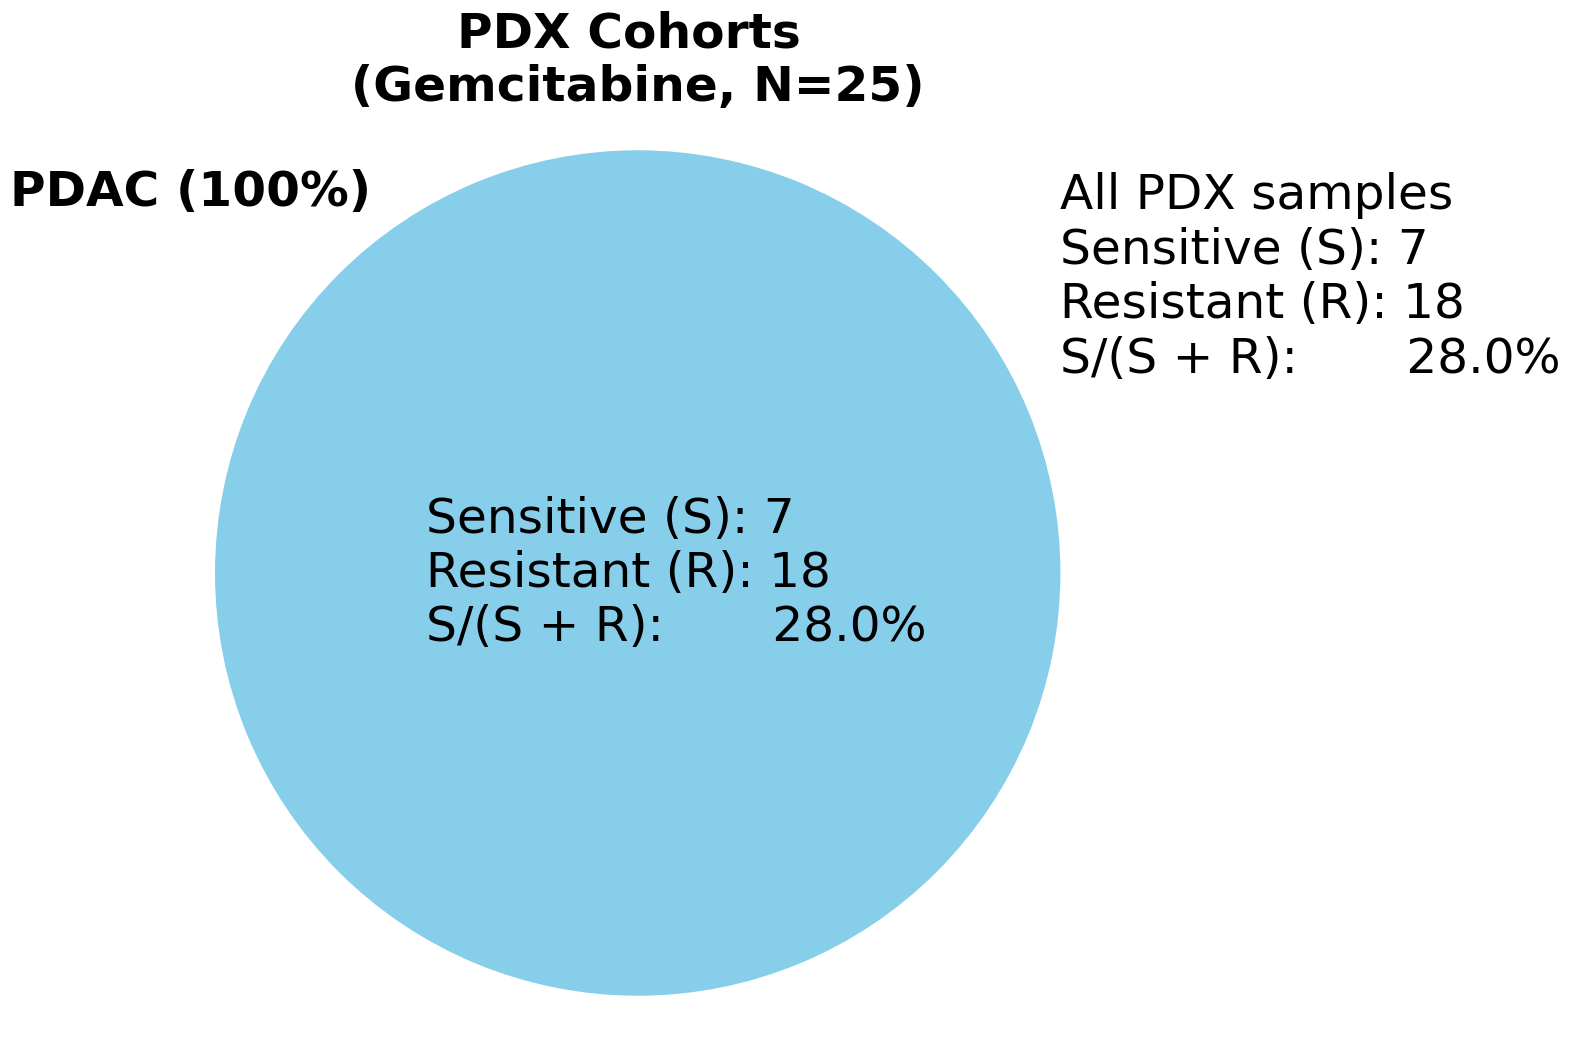

In [49]:
labels = list(dat_pdx["Tumor Type"].value_counts().index)
sizes = list(dat_pdx["Tumor Type"].value_counts().astype(int))
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(12, 12))
plt.pie(sizes, labels=labels_with_percentages, startangle=-55, colors=['skyblue'], textprops={'fontsize': 35, 'fontweight': 'bold'})
plt.title(f'PDX Cohorts \n(Gemcitabine, N={total})', fontweight = "bold", fontsize = 35)
plt.axis('equal')  

plt.text(-0.5, 0, 
         f'Sensitive (S): {PDXRgemcitabine["response"].value_counts()[1]} \nResistant (R): {PDXRgemcitabine["response"].value_counts()[0]} \nS/(S + R):       {round(PDXRgemcitabine["response"].value_counts()[1]/(sum(PDXRgemcitabine["response"].value_counts())) * 100, 2)}%', 
         fontsize=35, 
         color='black',
         va='center')

plt.text(1, 0.7, 
         f'All PDX samples\nSensitive (S): {PDXRgemcitabine["response"].value_counts()[1]} \nResistant (R): {PDXRgemcitabine["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(PDXRgemcitabine["response"].value_counts()[1]/(sum(PDXRgemcitabine["response"].value_counts())) * 100, 2)}%', 
         fontsize=35, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of PDX samples (Gemcitabine).png', format='png', bbox_inches='tight')

plt.show()

In [50]:
# filter PDAC cohort samples (Gemcitabine)

filter = (dat_pdx["Tumor Type"] == "PDAC")
pdx_pdac_samples = dat_pdx.loc[filter,].index
pdx_pdac_samples

Index(['X-1199', 'X-1289', 'X-1317', 'X-1362', 'X-2026', 'X-2043', 'X-2081',
       'X-2283', 'X-2339', 'X-2428', 'X-3052', 'X-3268', 'X-3782', 'X-3800',
       'X-3816', 'X-3846', 'X-3947', 'X-3990', 'X-4015', 'X-4226', 'X-4316',
       'X-4378', 'X-4649', 'X-4676', 'X-5205'],
      dtype='object')

In [51]:
# filter responses of PDAC cohort samples (Gemcitabine)

Ytsgemcitabine_pdx_pdac = PDXRgemcitabine.loc[pdx_pdac_samples,"response"].values
Ytsgemcitabine_pdx_pdac

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1])

In [52]:
# count of sensitive and resistant PDAC samples (Gemcitabine)

PDXRgemcitabine.loc[pdx_pdac_samples,"response"].value_counts()

response
0    18
1     7
Name: count, dtype: int64

In [53]:
# read TCGA response dataset (Gemcitabine)

TCGARgemcitabine = pd.read_csv("TCGA_response.Gemcitabine.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARgemcitabine.dropna(inplace=True)
TCGARgemcitabine.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARgemcitabine["response"] = TCGARgemcitabine.loc[:, "response"].apply(lambda x: d[x])
Ytsgemcitabine_tcga = TCGARgemcitabine["response"].values    

print(f"There are {Ytsgemcitabine_tcga.shape[0]} samples with response data in the TCGA (Gemcitabine)\n")
Ytsgemcitabine_tcga

There are 55 samples with response data in the TCGA (Gemcitabine)



array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0])

In [54]:
# TCGA cohort table with TCGA response dataset (Gemcitabine)

dat_tcga = TCGARgemcitabine["cohort"]

dat_tcga.value_counts()

cohort
PAAD    48
SARC     3
LIHC     2
LUSC     1
PCPG     1
Name: count, dtype: int64

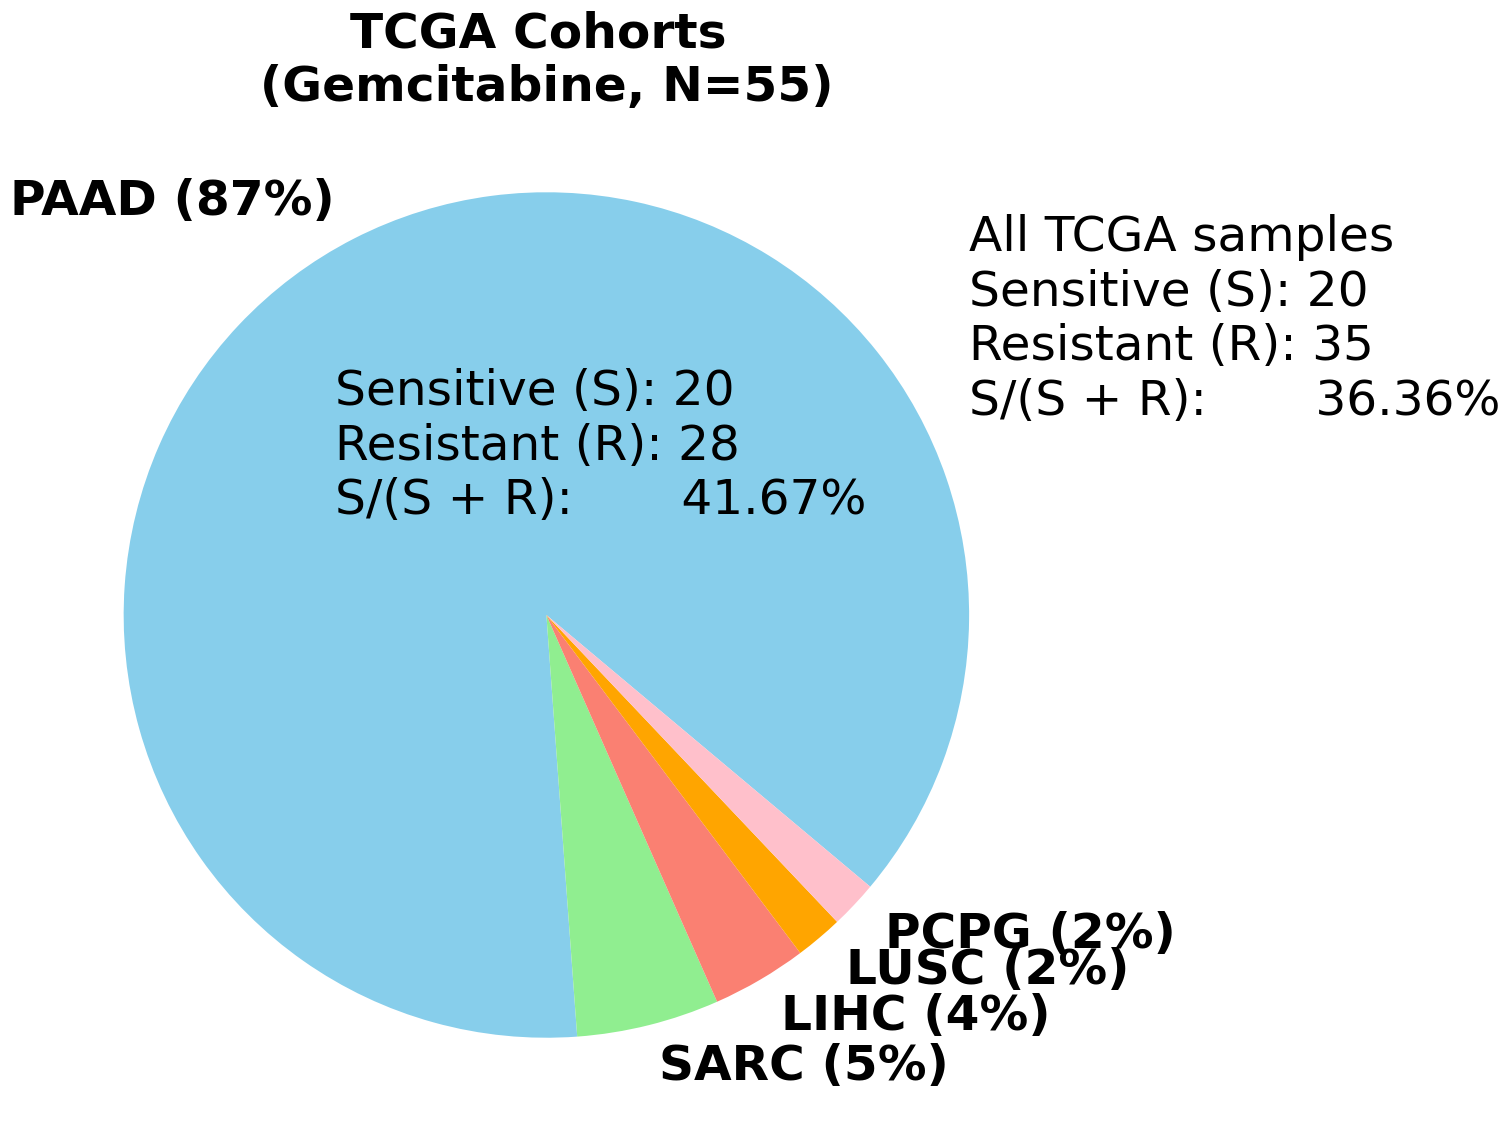

In [55]:
labels = list(dat_tcga.value_counts().index)
sizes = list(dat_tcga.value_counts())
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(12, 12))
plt.pie(sizes, labels=labels_with_percentages, startangle=-40, colors=['skyblue', 'lightgreen', 'salmon', 'orange', 'pink'], textprops={'fontsize': 35, 'fontweight': 'bold'})
plt.title(f'TCGA Cohorts \n(Gemcitabine, N={total})', fontweight = "bold", fontsize = 35)
plt.subplots_adjust(top=0.95) 
plt.axis('equal')  

#plt.text(0.4, -0.5, 
#         f'Sensitive (S): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "SARC","response"].value_counts().get(1,0)} \nResistant (R): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "SARC","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "SARC","response"].value_counts().get(1,0)/(sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "SARC","response"].value_counts())) * 100, 2)}%', 
#         fontsize=9, 
#         color='black',
#         va='center')
#
#plt.text(0.5, -0.3, 
#         f'Sensitive (S): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LIHC","response"].value_counts().get(1, 0)} \nResistant (R): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LIHC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LIHC","response"].value_counts().get(1,0)/(sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LIHC","response"].value_counts())) * 100, 2)}%', 
#         fontsize=9, 
#         color='black',
#         va='center')

plt.text(-0.5, 0.4, 
         f'Sensitive (S): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]} \nResistant (R): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]/(sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts())) * 100, 2)}%', 
         fontsize=35, 
         color='black',
         va='center')

#plt.text(0.1, -0.08, 
#         f'Sensitive (S): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LUSC","response"].value_counts().get(1,0)} \nResistant (R): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LUSC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LUSC","response"].value_counts().get(1,0)/(sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "LUSC","response"].value_counts())) * 100, 2)}%', 
#         fontsize=9, 
#         color='black',
#         va='center')
#
#plt.text(0.6, 0, 
#         f'Sensitive (S): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PCPG","response"].value_counts().get(1,0)} \nResistant (R): {TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PCPG","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PCPG","response"].value_counts().get(1,0)/(sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PCPG","response"].value_counts())) * 100, 2)}%', 
#         fontsize=9, 
#         color='black',
#         va='center')

plt.text(1, 0.7, 
         f'All TCGA samples\nSensitive (S): {TCGARgemcitabine["response"].value_counts()[1]} \nResistant (R): {TCGARgemcitabine["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARgemcitabine["response"].value_counts()[1]/(sum(TCGARgemcitabine["response"].value_counts())) * 100, 2)}%', 
         fontsize=35, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of TCGA samples (Gemcitabine).png', format='png', bbox_inches='tight')

plt.show()

In [56]:
# filter PAAD cohort samples (Gemcitabine)

filter = (TCGARgemcitabine["cohort"] == "PAAD")
tcga_paad_samples = dat_tcga.loc[filter,].index
tcga_paad_samples

Index(['TCGA-2L-AAQA-01A', 'TCGA-2L-AAQE-01A', 'TCGA-2L-AAQI-01A',
       'TCGA-2L-AAQJ-01A', 'TCGA-3A-A9I9-01A', 'TCGA-3A-A9IH-01A',
       'TCGA-3A-A9IX-01A', 'TCGA-3A-A9IZ-01A', 'TCGA-3A-A9J0-01A',
       'TCGA-F2-6879-01A', 'TCGA-F2-6880-01A', 'TCGA-F2-7273-01A',
       'TCGA-F2-7276-01A', 'TCGA-F2-A44G-01A', 'TCGA-F2-A44H-01A',
       'TCGA-F2-A8YN-01A', 'TCGA-FB-A5VM-01A', 'TCGA-FB-A78T-01A',
       'TCGA-FB-AAPP-01A', 'TCGA-FB-AAPY-01A', 'TCGA-FB-AAQ6-01A',
       'TCGA-H8-A6C1-01A', 'TCGA-HZ-7924-01A', 'TCGA-HZ-8317-01A',
       'TCGA-HZ-A49G-01A', 'TCGA-HZ-A49H-01A', 'TCGA-HZ-A77O-01A',
       'TCGA-HZ-A77P-01A', 'TCGA-IB-7644-01A', 'TCGA-IB-7647-01A',
       'TCGA-IB-7651-01A', 'TCGA-IB-7652-01A', 'TCGA-IB-7885-01A',
       'TCGA-IB-7889-01A', 'TCGA-IB-7891-01A', 'TCGA-IB-8127-01A',
       'TCGA-IB-A5SO-01A', 'TCGA-IB-A5SP-01A', 'TCGA-IB-A5SS-01A',
       'TCGA-IB-A6UF-01A', 'TCGA-IB-A7LX-01A', 'TCGA-IB-AAUO-01A',
       'TCGA-LB-A8F3-01A', 'TCGA-Q3-A5QY-01A', 'TCGA-RB-AA9M-0

In [57]:
# filter responses of PAAD cohort samples (Gemcitabine)

Ytsgemcitabine_tcga_paad = TCGARgemcitabine.loc[tcga_paad_samples,"response"].values
Ytsgemcitabine_tcga_paad

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0])

In [58]:
# count of sensitive and resistance _paad samples (Gemcitabine)

TCGARgemcitabine.loc[tcga_paad_samples,"response"].value_counts()

response
0    28
1    20
Name: count, dtype: int64

In [59]:
# maximum iteration

max_iter = 50

In [60]:
# use count of nodes and dropout rates found in trained pan-drug dataset

hdm1 = 16
hdm2 = 128
rate1 = 0.6
rate2 = 0.3
rate3 = 0.5

In [61]:
# load pre-trained modules and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEgemcitabine_pdx = scalerGDSC.transform(PDXEgemcitabine.values) 
X_testEgemcitabine_pdx_pdac = scalerGDSC.transform(PDXEgemcitabine.loc[pdx_pdac_samples,].values) 

X_testEgemcitabine_tcga = scalerGDSC.transform(TCGAEgemcitabine.values)    
X_testEgemcitabine_tcga_paad = scalerGDSC.transform(TCGAEgemcitabine.loc[tcga_paad_samples,].values)    

X_trainM = np.nan_to_num(GDSCMv2.values)
X_testMgemcitabine_pdx = np.nan_to_num(PDXMgemcitabine.values.astype(np.float32))
X_testMgemcitabine_pdx_pdac = np.nan_to_num(PDXMgemcitabine.loc[pdx_pdac_samples,].values.astype(np.float32))
X_testMgemcitabine_tcga = np.nan_to_num(TCGAMgemcitabine.values.astype(np.float32))
X_testMgemcitabine_tcga_paad = np.nan_to_num(TCGAMgemcitabine.loc[tcga_paad_samples,].values.astype(np.float32))

TX_testEgemcitabine_pdx = torch.FloatTensor(X_testEgemcitabine_pdx)
TX_testEgemcitabine_pdx_pdac = torch.FloatTensor(X_testEgemcitabine_pdx_pdac)

TX_testMgemcitabine_pdx = torch.FloatTensor(X_testMgemcitabine_pdx.astype(np.float32))
TX_testMgemcitabine_pdx_pdac = torch.FloatTensor(X_testMgemcitabine_pdx_pdac.astype(np.float32))

ty_testEgemcitabine_pdx = torch.FloatTensor(Ytsgemcitabine_pdx.astype(int))
ty_testEgemcitabine_pdx_pdac = torch.FloatTensor(Ytsgemcitabine_pdx_pdac.astype(int))

TX_testEgemcitabine_tcga = torch.FloatTensor(X_testEgemcitabine_tcga)
TX_testEgemcitabine_tcga_paad = torch.FloatTensor(X_testEgemcitabine_tcga_paad)

TX_testMgemcitabine_tcga = torch.FloatTensor(X_testMgemcitabine_tcga.astype(np.float32))
TX_testMgemcitabine_tcga_paad = torch.FloatTensor(X_testMgemcitabine_tcga_paad.astype(np.float32))

ty_testEgemcitabine_tcga = torch.FloatTensor(Ytsgemcitabine_tcga.astype(int))
ty_testEgemcitabine_tcga_paad = torch.FloatTensor(Ytsgemcitabine_tcga_paad.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampM, IM_dim = X_trainM.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEM(nn.Module):
    def __init__(self):
        super(AEM, self).__init__()
        self.EnM = torch.nn.Sequential(
            nn.Linear(IM_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnM(x)
        return output       
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy.pt")
AutoencoderM = torch.load(models_dir + "Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy.pt")

Clas = torch.load(models_dir + "Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy.pt")

AutoencoderE.eval()
AutoencoderM.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZMX = AutoencoderM(torch.FloatTensor(X_trainM))
ZTX = torch.cat((ZEX, ZMX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())

ZETgemcitabine_pdx = AutoencoderE(TX_testEgemcitabine_pdx)
ZMTgemcitabine_pdx = AutoencoderM(TX_testMgemcitabine_pdx)
ZTTgemcitabine_pdx = torch.cat((ZETgemcitabine_pdx, ZMTgemcitabine_pdx), 1)
ZTTgemcitabine_pdx = F.normalize(ZTTgemcitabine_pdx, p=2, dim=0)
PredTgemcitabine_pdx = Clas(ZTTgemcitabine_pdx)
AUCTgemcitabine_pdx = roc_auc_score(Ytsgemcitabine_pdx.astype(int), PredTgemcitabine_pdx.detach().numpy())
AUCTgemcitabine_pdx_aucpr = average_precision_score(Ytsgemcitabine_pdx.astype(int), PredTgemcitabine_pdx.detach().numpy())

ZETgemcitabine_pdx_pdac = AutoencoderE(TX_testEgemcitabine_pdx_pdac)
ZMTgemcitabine_pdx_pdac = AutoencoderM(TX_testMgemcitabine_pdx_pdac)
ZTTgemcitabine_pdx_pdac = torch.cat((ZETgemcitabine_pdx_pdac, ZMTgemcitabine_pdx_pdac), 1)
ZTTgemcitabine_pdx_pdac = F.normalize(ZTTgemcitabine_pdx_pdac, p=2, dim=0)
PredTgemcitabine_pdx_pdac = Clas(ZTTgemcitabine_pdx_pdac)
AUCTgemcitabine_pdx_pdac = roc_auc_score(Ytsgemcitabine_pdx_pdac.astype(int), PredTgemcitabine_pdx_pdac.detach().numpy())
AUCTgemcitabine_pdx_pdac_aucpr = average_precision_score(Ytsgemcitabine_pdx_pdac.astype(int), PredTgemcitabine_pdx_pdac.detach().numpy())

ZETgemcitabine_tcga = AutoencoderE(TX_testEgemcitabine_tcga)
ZMTgemcitabine_tcga = AutoencoderM(TX_testMgemcitabine_tcga)
ZTTgemcitabine_tcga = torch.cat((ZETgemcitabine_tcga, ZMTgemcitabine_tcga), 1)
ZTTgemcitabine_tcga = F.normalize(ZTTgemcitabine_tcga, p=2, dim=0)
PredTgemcitabine_tcga = Clas(ZTTgemcitabine_tcga)
AUCTgemcitabine_tcga = roc_auc_score(Ytsgemcitabine_tcga.astype(int), PredTgemcitabine_tcga.detach().numpy())
AUCTgemcitabine_tcga_aucpr = average_precision_score(Ytsgemcitabine_tcga.astype(int), PredTgemcitabine_tcga.detach().numpy())

ZETgemcitabine_tcga_paad = AutoencoderE(TX_testEgemcitabine_tcga_paad)
ZMTgemcitabine_tcga_paad = AutoencoderM(TX_testMgemcitabine_tcga_paad)
ZTTgemcitabine_tcga_paad = torch.cat((ZETgemcitabine_tcga_paad, ZMTgemcitabine_tcga_paad), 1)
ZTTgemcitabine_tcga_paad = F.normalize(ZTTgemcitabine_tcga_paad, p=2, dim=0)
PredTgemcitabine_tcga_paad = Clas(ZTTgemcitabine_tcga_paad)
AUCTgemcitabine_tcga_paad = roc_auc_score(Ytsgemcitabine_tcga_paad.astype(int), PredTgemcitabine_tcga_paad.detach().numpy())
AUCTgemcitabine_tcga_paad_aucpr = average_precision_score(Ytsgemcitabine_tcga_paad.astype(int), PredTgemcitabine_tcga_paad.detach().numpy())

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTgemcitabine_pdx_finetuned = dict()
AUCTgemcitabine_tcga_finetuned = dict()
AUCTgemcitabine_pdx_pdac_finetuned = dict()
AUCTgemcitabine_tcga_paad_finetuned = dict()
AUCTgemcitabine_pdx_aucpr_finetuned = dict()
AUCTgemcitabine_tcga_aucpr_finetuned = dict()
AUCTgemcitabine_pdx_pdac_aucpr_finetuned = dict()
AUCTgemcitabine_tcga_paad_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(finetuned_dir + f"Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{iter}.pt")
   AutoencoderM_finetuned = torch.load(finetuned_dir + f"Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(finetuned_dir + f"Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderM_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZMX = AutoencoderM_finetuned(torch.FloatTensor(X_trainM))
   ZTX = torch.cat((ZEX, ZMX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETgemcitabine_pdx = AutoencoderE_finetuned(TX_testEgemcitabine_pdx)
   ZMTgemcitabine_pdx = AutoencoderM_finetuned(TX_testMgemcitabine_pdx)
   ZTTgemcitabine_pdx = torch.cat((ZETgemcitabine_pdx, ZMTgemcitabine_pdx), 1)
   ZTTgemcitabine_pdx = F.normalize(ZTTgemcitabine_pdx, p=2, dim=0)
   PredTgemcitabine_pdx = Clas_finetuned(ZTTgemcitabine_pdx)
   AUCTgemcitabine_pdx_finetuned[iter] = roc_auc_score(Ytsgemcitabine_pdx.astype(int), PredTgemcitabine_pdx.detach().numpy())
   AUCTgemcitabine_pdx_aucpr_finetuned[iter] = average_precision_score(Ytsgemcitabine_pdx.astype(int), PredTgemcitabine_pdx.detach().numpy())

   ZETgemcitabine_pdx_pdac = AutoencoderE_finetuned(TX_testEgemcitabine_pdx_pdac)
   ZMTgemcitabine_pdx_pdac = AutoencoderM_finetuned(TX_testMgemcitabine_pdx_pdac)
   ZTTgemcitabine_pdx_pdac = torch.cat((ZETgemcitabine_pdx_pdac, ZMTgemcitabine_pdx_pdac), 1)
   ZTTgemcitabine_pdx_pdac = F.normalize(ZTTgemcitabine_pdx_pdac, p=2, dim=0)
   PredTgemcitabine_pdx_pdac = Clas_finetuned(ZTTgemcitabine_pdx_pdac)
   AUCTgemcitabine_pdx_pdac_finetuned[iter] = roc_auc_score(Ytsgemcitabine_pdx_pdac.astype(int), PredTgemcitabine_pdx_pdac.detach().numpy())
   AUCTgemcitabine_pdx_pdac_aucpr_finetuned[iter] = average_precision_score(Ytsgemcitabine_pdx_pdac.astype(int), PredTgemcitabine_pdx_pdac.detach().numpy())

   ZETgemcitabine_tcga = AutoencoderE_finetuned(TX_testEgemcitabine_tcga)
   ZMTgemcitabine_tcga = AutoencoderM_finetuned(TX_testMgemcitabine_tcga)
   ZTTgemcitabine_tcga = torch.cat((ZETgemcitabine_tcga, ZMTgemcitabine_tcga), 1)
   ZTTgemcitabine_tcga = F.normalize(ZTTgemcitabine_tcga, p=2, dim=0)
   PredTgemcitabine_tcga = Clas_finetuned(ZTTgemcitabine_tcga)
   AUCTgemcitabine_tcga_finetuned[iter] = roc_auc_score(Ytsgemcitabine_tcga.astype(int), PredTgemcitabine_tcga.detach().numpy())
   AUCTgemcitabine_tcga_aucpr_finetuned[iter] = average_precision_score(Ytsgemcitabine_tcga.astype(int), PredTgemcitabine_tcga.detach().numpy())

   ZETgemcitabine_tcga_paad = AutoencoderE_finetuned(TX_testEgemcitabine_tcga_paad)
   ZMTgemcitabine_tcga_paad = AutoencoderM_finetuned(TX_testMgemcitabine_tcga_paad)
   ZTTgemcitabine_tcga_paad = torch.cat((ZETgemcitabine_tcga_paad, ZMTgemcitabine_tcga_paad), 1)
   ZTTgemcitabine_tcga_paad = F.normalize(ZTTgemcitabine_tcga_paad, p=2, dim=0)
   PredTgemcitabine_tcga_paad = Clas_finetuned(ZTTgemcitabine_tcga_paad)
   AUCTgemcitabine_tcga_paad_finetuned[iter] = roc_auc_score(Ytsgemcitabine_tcga_paad.astype(int), PredTgemcitabine_tcga_paad.detach().numpy())
   AUCTgemcitabine_tcga_paad_aucpr_finetuned[iter] = average_precision_score(Ytsgemcitabine_tcga_paad.astype(int), PredTgemcitabine_tcga_paad.detach().numpy())

max_key_pdx = max(AUCTgemcitabine_pdx_aucpr_finetuned, key=AUCTgemcitabine_pdx_aucpr_finetuned.get)
max_key_pdx_pdac = max(AUCTgemcitabine_pdx_pdac_aucpr_finetuned, key=AUCTgemcitabine_pdx_pdac_aucpr_finetuned.get)
max_key_tcga = max(AUCTgemcitabine_tcga_aucpr_finetuned, key=AUCTgemcitabine_tcga_aucpr_finetuned.get)
max_key_tcga_paad = max(AUCTgemcitabine_tcga_paad_aucpr_finetuned, key=AUCTgemcitabine_tcga_paad_aucpr_finetuned.get)

print(f"GDSC - Training AUC (DNA_REPi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (DNA_REPi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (Gemcitabine): {round(AUCTgemcitabine_pdx,2)}")
print(f"PDX - Test AUCPR (Gemcitabine): {round(AUCTgemcitabine_pdx_aucpr,2)}")
print(f"PDX - Test AUC (Gemcitabine, PDAC): {round(AUCTgemcitabine_pdx_pdac,2)}")
print(f"PDX - Test AUCPR (Gemcitabine, PDAC): {round(AUCTgemcitabine_pdx_pdac_aucpr,2)}")
print(f"TCGA - Test AUC (Gemcitabine): {round(AUCTgemcitabine_tcga,2)}")
print(f"TCGA - Test AUCPR (Gemcitabine): {round(AUCTgemcitabine_tcga_aucpr,2)}")
print(f"TCGA - Test AUC (Gemcitabine, PAAD): {round(AUCTgemcitabine_tcga_paad,2)}")
print(f"TCGA - Test AUCPR (Gemcitabine, PAAD): {round(AUCTgemcitabine_tcga_paad_aucpr,2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_pdx],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUC (Gemcitabine, Finetuned): {round(AUCTgemcitabine_pdx_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUCPR (Gemcitabine, Finetuned): {round(AUCTgemcitabine_pdx_aucpr_finetuned[max_key_pdx],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_pdx_pdac],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx_pdac],2)}")
print(f"PDX - Test AUC (Gemcitabine, PDAC, Finetuned): {round(AUCTgemcitabine_pdx_pdac_finetuned[max_key_pdx_pdac],2)}")
print(f"PDX - Test AUCPR (Gemcitabine, PDAC, Finetuned): {round(AUCTgemcitabine_pdx_pdac_aucpr_finetuned[max_key_pdx_pdac],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_tcga],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUC (Gemcitabine, Finetuned): {round(AUCTgemcitabine_tcga_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUCPR (Gemcitabine, Finetuned): {round(AUCTgemcitabine_tcga_aucpr_finetuned[max_key_tcga],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_tcga_paad],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga_paad],2)}")
print(f"TCGA - Test AUC (Gemcitabine, PAAD, Finetuned): {round(AUCTgemcitabine_tcga_paad_finetuned[max_key_tcga_paad],2)}")
print(f"TCGA - Test AUCPR (Gemcitabine, PAAD, Finetuned): {round(AUCTgemcitabine_tcga_paad_aucpr_finetuned[max_key_tcga_paad],2)}\n\n")

print("Models for maximum finetuning (Gemcitabine, PDX)")
print(f"Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_pdx}.pt")

print("\nModels for maximum finetuning (Gemcitabine, PDX, PDAC)")
print(f"Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_pdx_pdac}.pt")
print(f"Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_pdx_pdac}.pt")
print(f"Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_pdx_pdac}.pt")

print("\nModels for maximum finetuning (Gemcitabine, TCGA)")
print(f"Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_tcga}.pt")

print("\nModels for maximum finetuning (Gemcitabine, TCGA, PAAD)")
print(f"Exprs_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_tcga_paad}.pt")
print(f"Mut_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_tcga_paad}.pt")
print(f"Class_Gemcitabine_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_First_Strategy_Finetuned_{max_key_tcga_paad}.pt")


GDSC - Training AUC (DNA_REPi): 0.8
GDSC - Training AUCPR (DNA_REPi): 0.33
PDX - Test AUC (Gemcitabine): 0.44
PDX - Test AUCPR (Gemcitabine): 0.29
PDX - Test AUC (Gemcitabine, PDAC): 0.44
PDX - Test AUCPR (Gemcitabine, PDAC): 0.29
TCGA - Test AUC (Gemcitabine): 0.61
TCGA - Test AUCPR (Gemcitabine): 0.44
TCGA - Test AUC (Gemcitabine, PAAD): 0.59
TCGA - Test AUCPR (Gemcitabine, PAAD): 0.48

GDSC - Training AUC (DNA_REPi, Finetuned): 0.81
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.34
PDX - Test AUC (Gemcitabine, Finetuned): 0.57
PDX - Test AUCPR (Gemcitabine, Finetuned): 0.35

GDSC - Training AUC (DNA_REPi, Finetuned): 0.81
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.34
PDX - Test AUC (Gemcitabine, PDAC, Finetuned): 0.57
PDX - Test AUCPR (Gemcitabine, PDAC, Finetuned): 0.35

GDSC - Training AUC (DNA_REPi, Finetuned): 0.81
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.34
TCGA - Test AUC (Gemcitabine, Finetuned): 0.64
TCGA - Test AUCPR (Gemcitabine, Finetuned): 0.46

GDSC - Training

In [62]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=710, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
)

In [63]:
# show mutation layer parameters

AutoencoderM

AEM(
  (EnM): Sequential(
    (0): Linear(in_features=710, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
)

In [64]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=144, out_features=1, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
)

In [65]:
# create a dataframe with the prediction results 

em  = {"Data": ["Expr + Mut", "Expr + Mut (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key_pdx], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX)": [round(AUCTgemcitabine_pdx,2), round(AUCTgemcitabine_pdx_finetuned[max_key_pdx],2)],
       "AUCPR (PDX)":  [round(AUCTgemcitabine_pdx_aucpr,2), round(AUCTgemcitabine_pdx_aucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX-PDAC)":  [round(AUCTgemcitabine_pdx_pdac,2), round(AUCTgemcitabine_pdx_pdac_finetuned[max_key_pdx_pdac],2)],
       "AUCPR (PDX-PDAC)": [round(AUCTgemcitabine_pdx_pdac_aucpr,2), round(AUCTgemcitabine_pdx_pdac_aucpr_finetuned[max_key_pdx_pdac],2)],
       "AUC (TCGA)": [round(AUCTgemcitabine_tcga,2), round(AUCTgemcitabine_tcga_finetuned[max_key_tcga],2)],
       "AUCPR (TCGA)":  [round(AUCTgemcitabine_tcga_aucpr,2), round(AUCTgemcitabine_tcga_aucpr_finetuned[max_key_tcga],2)],
       "AUC (TCGA-PAAD)":  [round(AUCTgemcitabine_tcga_paad,2), round(AUCTgemcitabine_tcga_paad_finetuned[max_key_tcga_paad],2)],
       "AUCPR (TCGA-PAAD)": [round(AUCTgemcitabine_tcga_paad_aucpr,2), round(AUCTgemcitabine_tcga_paad_aucpr_finetuned[max_key_tcga_paad],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}

em_dataframe = pd.DataFrame.from_dict(em, orient='index').transpose() 
os.makedirs(save_results_to, exist_ok = True)
em_dataframe.to_csv(save_results_to + "GDSC_PDX_TCGA_Expression_Mutation_DNA_REPi_Gemcitabine_First_Strategy.tsv",
                     sep = "\t",
                     index = False)

em_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytsgemcitabine_pdx)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytsgemcitabine_pdx)) + ")",
    "AUC (PDX-PDAC)": "AUC (PDX-PDAC, N=" + str(len(Ytsgemcitabine_pdx_pdac)) + ")",
    "AUCPR (PDX-PDAC)": "AUCPR (PDX-PDAC, N=" + str(len(Ytsgemcitabine_pdx_pdac)) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytsgemcitabine_tcga)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytsgemcitabine_tcga)) + ")",
    "AUC (TCGA-PAAD)": "AUC (TCGA-PAAD, N=" + str(len(Ytsgemcitabine_tcga_paad)) + ")",
    "AUCPR (TCGA-PAAD)": "AUCPR (TCGA-PAAD, N=" + str(len(Ytsgemcitabine_tcga_paad)) + ")"
    }, inplace = True
)

em_dataframe

,Data,"AUC (GDSC, N=9435)","AUCPR (GDSC, N=9435)","AUC (PDX, N=25)","AUCPR (PDX, N=25)","AUC (PDX-PDAC, N=25)","AUCPR (PDX-PDAC, N=25)","AUC (TCGA, N=55)","AUCPR (TCGA, N=55)","AUC (TCGA-PAAD, N=48)","AUCPR (TCGA-PAAD, N=48)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + Mut,0.8,0.33,0.44,0.29,0.44,0.29,0.61,0.44,0.59,0.48,9435,710
1,Expr + Mut (Fine-tuned),0.81,0.34,0.57,0.35,0.57,0.35,0.64,0.46,0.63,0.49,9435,710


In [66]:
# merge all EM, EC, and EMC dataframes 

ec_dataframe = pd.read_csv(ec_dir + "GDSC_PDX_TCGA_Expression_CNA_DNA_REPi_Gemcitabine_First_Strategy.tsv",
                           sep = "\t")
ec_dataframe.columns = em_dataframe.columns

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_TCGA_Expression_Mutation_CNA_DNA_REPi_Gemcitabine_First_Strategy.tsv",
                           sep = "\t")
emc_dataframe.columns = em_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=9435)","AUCPR (GDSC, N=9435)","AUC (PDX, N=25)","AUCPR (PDX, N=25)","AUC (PDX-PDAC, N=25)","AUCPR (PDX-PDAC, N=25)","AUC (TCGA, N=55)","AUCPR (TCGA, N=55)","AUC (TCGA-PAAD, N=48)","AUCPR (TCGA-PAAD, N=48)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,,,,,
Expr + Mut + CNA,0.82,0.34,0.58,0.5,0.58,0.5,0.55,0.4,0.54,0.45,9435,654
Expr + Mut + CNA (Fine-tuned),0.83,0.34,0.67,0.57,0.67,0.57,0.56,0.42,0.54,0.5,9435,654
Expr + CNA,0.81,0.32,0.3,0.23,0.3,0.23,0.58,0.41,0.64,0.56,9435,772
Expr + CNA (Fine-tuned),0.81,0.33,0.4,0.26,0.4,0.26,0.62,0.43,0.67,0.62,9435,772
Expr + Mut,0.8,0.33,0.44,0.29,0.44,0.29,0.61,0.44,0.59,0.48,9435,710
Expr + Mut (Fine-tuned),0.81,0.34,0.57,0.35,0.57,0.35,0.64,0.46,0.63,0.49,9435,710


In [67]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytsgemcitabine_pdx))})",
                               f"AUC (PDX-PDAC, N={str(len(Ytsgemcitabine_pdx_pdac))})",
                               f"AUC (TCGA, N={str(len(Ytsgemcitabine_tcga))})",
                               f"AUC (TCGA-PAAD, N={str(len(Ytsgemcitabine_tcga_paad))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytsgemcitabine_pdx))})": f"PDX (N={str(len(Ytsgemcitabine_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRgemcitabine["response"].value_counts()[1]) + ", R=" + str(PDXRgemcitabine["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRgemcitabine["response"].value_counts()[1]/sum(PDXRgemcitabine["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-PDAC, N={str(len(Ytsgemcitabine_pdx_pdac))})": f"PDX-PDAC (N={str(len(Ytsgemcitabine_pdx_pdac))}, p=" + str(PDXEgemcitabine.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA, N={str(len(Ytsgemcitabine_tcga))})": f"TCGA (N={str(len(Ytsgemcitabine_tcga))}, p=" + str(PDXEgemcitabine.shape[1]) + "\nS=" + str(TCGARgemcitabine["response"].value_counts()[1]) + ", R=" + str(TCGARgemcitabine["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARgemcitabine["response"].value_counts()[1]/sum(TCGARgemcitabine["response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA-PAAD, N={str(len(Ytsgemcitabine_tcga_paad))})": f"TCGA-PAAD (N={str(len(Ytsgemcitabine_tcga_paad))}, p=" + str(TCGAEgemcitabine.shape[1]) + "\nS=" + str(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]) + ", R=" + str(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]/sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=9435, p=710\nS=835, R=8600, S/N=0.09)","PDX (N=25, p=710\nS=7, R=18, S/N=0.28)","PDX-PDAC (N=25, p=710\nS=7, R=18, S/N=0.28)","TCGA (N=55, p=710\nS=20, R=35, S/N=0.36)","TCGA-PAAD (N=48, p=710\nS=20, R=28, S/N=0.42)"
Data,,,,,
Expr + Mut + CNA,0.82,0.58,0.58,0.55,0.54
Expr + Mut + CNA (Fine-tuned),0.83,0.67,0.67,0.56,0.54
Expr + CNA,0.81,0.3,0.3,0.58,0.64
Expr + CNA (Fine-tuned),0.81,0.4,0.4,0.62,0.67
Expr + Mut,0.8,0.44,0.44,0.61,0.59
Expr + Mut (Fine-tuned),0.81,0.57,0.57,0.64,0.63


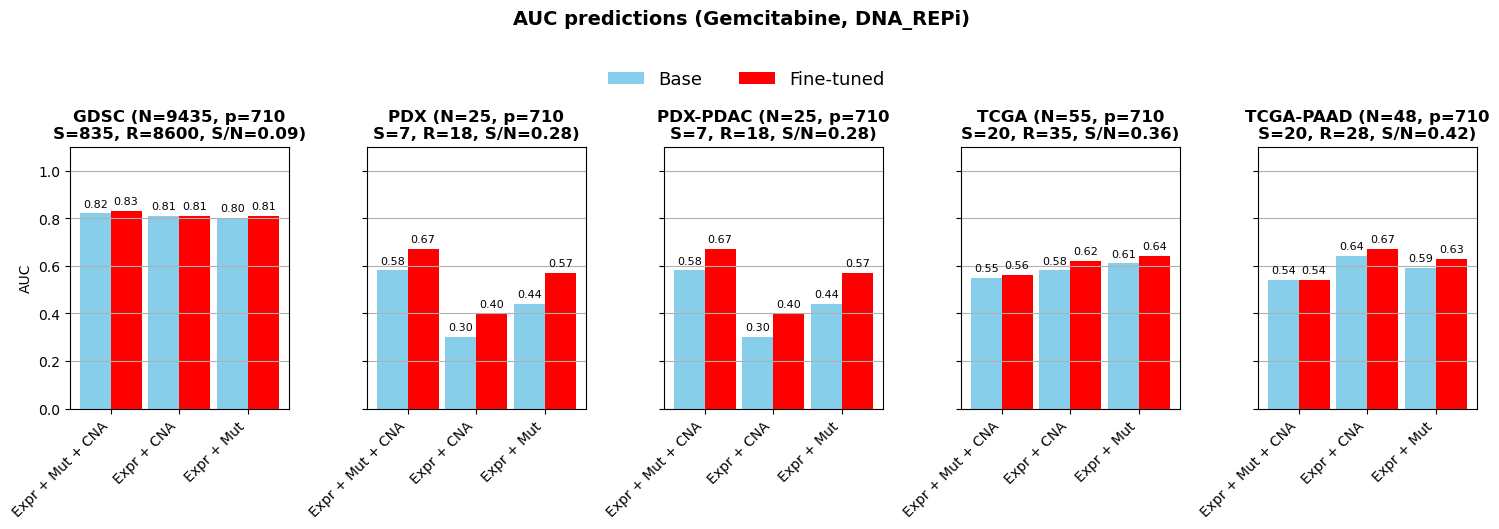

In [68]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Gemcitabine, DNA_REPi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Gemcitabine, DNA_REPi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [69]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUCPR (PDX, N={str(len(Ytsgemcitabine_pdx))})",
                               f"AUCPR (PDX-PDAC, N={str(len(Ytsgemcitabine_pdx_pdac))})",
                               f"AUCPR (TCGA, N={str(len(Ytsgemcitabine_tcga))})",
                               f"AUCPR (TCGA-PAAD, N={str(len(Ytsgemcitabine_tcga_paad))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytsgemcitabine_pdx))})": f"PDX (N={str(len(Ytsgemcitabine_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRgemcitabine["response"].value_counts()[1]) + ", R=" + str(PDXRgemcitabine["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRgemcitabine["response"].value_counts()[1]/sum(PDXRgemcitabine["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-PDAC, N={str(len(Ytsgemcitabine_pdx_pdac))})": f"PDX-PDAC (N={str(len(Ytsgemcitabine_pdx_pdac))}, p=" + str(PDXEgemcitabine.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "PDAC","response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA, N={str(len(Ytsgemcitabine_tcga))})": f"TCGA (N={str(len(Ytsgemcitabine_tcga))}, p=" + str(PDXEgemcitabine.shape[1]) + "\nS=" + str(TCGARgemcitabine["response"].value_counts()[1]) + ", R=" + str(TCGARgemcitabine["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARgemcitabine["response"].value_counts()[1]/sum(TCGARgemcitabine["response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA-PAAD, N={str(len(Ytsgemcitabine_tcga_paad))})": f"TCGA-PAAD (N={str(len(Ytsgemcitabine_tcga_paad))}, p=" + str(TCGAEgemcitabine.shape[1]) + "\nS=" + str(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]) + ", R=" + str(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()[1]/sum(TCGARgemcitabine.loc[TCGARgemcitabine["cohort"] == "PAAD","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=9435, p=710\nS=835, R=8600, S/N=0.09)","PDX (N=25, p=710\nS=7, R=18, S/N=0.28)","PDX-PDAC (N=25, p=710\nS=7, R=18, S/N=0.28)","TCGA (N=55, p=710\nS=20, R=35, S/N=0.36)","TCGA-PAAD (N=48, p=710\nS=20, R=28, S/N=0.42)"
Data,,,,,
Expr + Mut + CNA,0.34,0.5,0.5,0.4,0.45
Expr + Mut + CNA (Fine-tuned),0.34,0.57,0.57,0.42,0.5
Expr + CNA,0.32,0.23,0.23,0.41,0.56
Expr + CNA (Fine-tuned),0.33,0.26,0.26,0.43,0.62
Expr + Mut,0.33,0.29,0.29,0.44,0.48
Expr + Mut (Fine-tuned),0.34,0.35,0.35,0.46,0.49


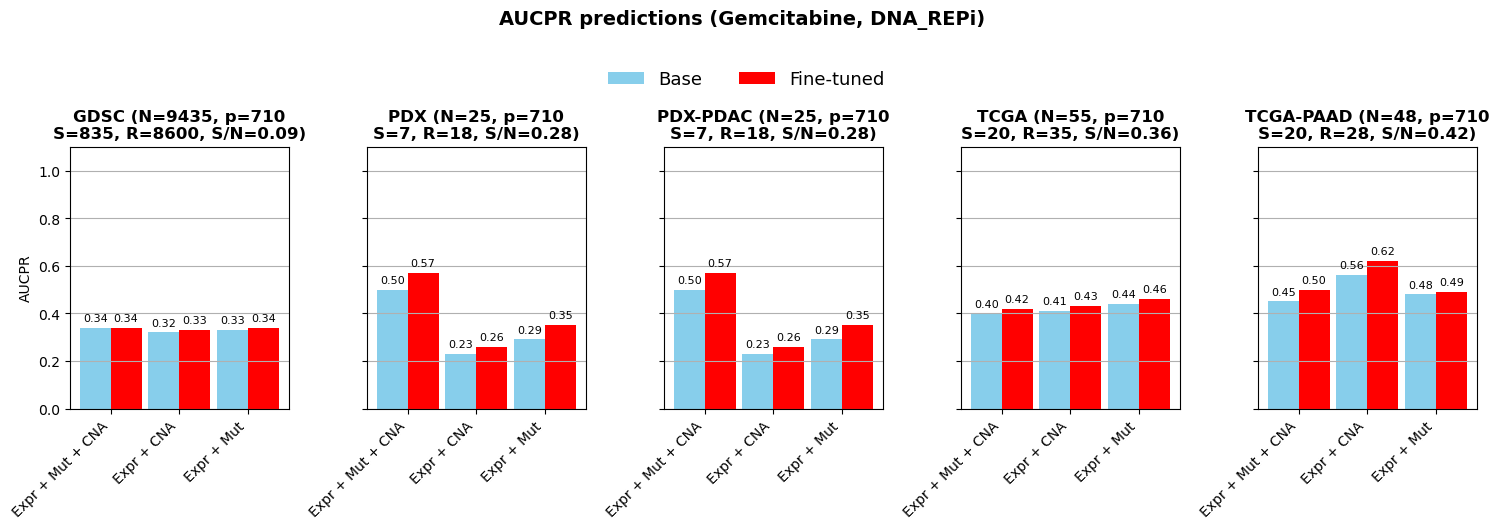

In [70]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Gemcitabine, DNA_REPi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Gemcitabine, DNA_REPi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [71]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_First_Strategy


In [72]:
# save predictions

file = open('GDSC_PDX_TCGA_DNA_REPi_Gemcitabine_Predictions_First_Strategy (Expression and Mutation).txt', 'w')
file.write(f"GDSC Training (EM) AUC (DNA_REPi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EM) AUCPR (DNA_REPi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Gemcitabine): {round(AUCTgemcitabine_pdx,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Gemcitabine): {round(AUCTgemcitabine_pdx_aucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Gemcitabine, PDAC): {round(AUCTgemcitabine_pdx_pdac,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Gemcitabine, PDAC): {round(AUCTgemcitabine_pdx_pdac_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (Gemcitabine): {round(AUCTgemcitabine_tcga,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (Gemcitabine): {round(AUCTgemcitabine_tcga_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (Gemcitabine, PAAD): {round(AUCTgemcitabine_tcga_paad,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (Gemcitabine, PAAD): {round(AUCTgemcitabine_tcga_paad_aucpr,2)}\n")

file.close()

In [73]:
# get Gene symbols from Entrez ID

gene_list = mg.querymany(GDSCEv2.columns, 
                         species="human", 
                         scopes = "entrezgene",
                         field = "symbol",
                         as_dataframe=True)["symbol"]
gene_list

query
118788    PIK3AP1
2059         EPS8
8204        NRIP1
10253       SPRY2
79887       PLBD1
           ...   
51176        LEF1
10217      CTDSPL
51186      TCEAL9
4082       MARCKS
90102      PHLDB2
Name: symbol, Length: 710, dtype: object

In [74]:
# change directory to read DEG file (Gemcitabine)

os.chdir(gemcitabine_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi/gemcitabine


In [75]:
# read DEG file (Gemcitabine)

gemcitabine_DEGs_data = pd.read_excel("Limma Results (EnsemblID).xlsx")
gemcitabine_DEGs_data = gemcitabine_DEGs_data.set_index('ID', drop=True)
gemcitabine_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
ID,,,,,,
ENSG00000186867,-0.423896,3.156996,-5.316613,1.390706e-07,0.002534,6.510530
ENSG00000172716,-1.496342,5.062466,-5.132853,3.626992e-07,0.003305,5.700686
ENSG00000111252,-0.472950,4.087448,-4.697139,3.130313e-06,0.017659,3.886255
ENSG00000157796,-0.635183,5.898472,-4.652008,3.876243e-06,0.017659,3.706906
ENSG00000187109,-0.428662,8.326084,-4.502217,7.778711e-06,0.022920,3.123297


In [76]:
# get Gene symbols from Ensembl gene IDs

gene_symbols = mg.querymany(gemcitabine_DEGs_data.index, 
                              species="human", 
                              scopes = "ensembl.gene",
                              field = "symbol",
                              as_dataframe=True)["symbol"]
gene_symbols

1 input query terms found dup hits:	[('ENSG00000226506', 2)]
15 input query terms found no hit:	['ENSG00000239332', 'ENSG00000212978', 'ENSG00000291025', 'ENSG00000263574', 'ENSG00000276397', 'ENS


query
ENSG00000186867       QRFPR
ENSG00000172716      SLFN11
ENSG00000111252       SH2B3
ENSG00000157796       WDR19
ENSG00000187109      NAP1L1
                     ...   
ENSG00000179542     SLITRK4
ENSG00000205784      ARRDC5
ENSG00000104880    ARHGEF18
ENSG00000129103       SUMF2
ENSG00000208892     SNORA49
Name: symbol, Length: 18224, dtype: object

In [77]:
# merge Gene symbol column to the table

gemcitabine_merged_DEGs_data = pd.merge(gemcitabine_DEGs_data, pd.DataFrame(gene_symbols),  
                                       left_index=True, 
                                       right_index=True, 
                                       how='inner')

gemcitabine_merged_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol
ID,,,,,,,
ENSG00000186867,-0.423896,3.156996,-5.316613,1.390706e-07,0.002534,6.510530,QRFPR
ENSG00000172716,-1.496342,5.062466,-5.132853,3.626992e-07,0.003305,5.700686,SLFN11
ENSG00000111252,-0.472950,4.087448,-4.697139,3.130313e-06,0.017659,3.886255,SH2B3
ENSG00000157796,-0.635183,5.898472,-4.652008,3.876243e-06,0.017659,3.706906,WDR19
ENSG00000187109,-0.428662,8.326084,-4.502217,7.778711e-06,0.022920,3.123297,NAP1L1


In [78]:
# subset DEGs in dataframe

filter = gemcitabine_merged_DEGs_data["symbol"].isin(gene_list)
gemcitabine_merged_DEGs_data = gemcitabine_merged_DEGs_data.loc[filter,:]

gemcitabine_merged_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol
ID,,,,,,,
ENSG00000172716,-1.496342,5.062466,-5.132853,3.626992e-07,0.003305,5.700686,SLFN11
ENSG00000182601,-0.494020,3.113752,-3.557060,3.982516e-04,0.188435,-0.139860,HS3ST4
ENSG00000214530,0.870639,6.103503,3.445739,6.007391e-04,0.196545,-0.475855,STARD10
ENSG00000163565,-1.287004,7.814074,-3.295805,1.026896e-03,0.216681,-0.912078,IFI16
ENSG00000115339,1.192324,5.862242,3.286287,1.061726e-03,0.216681,-0.939136,GALNT3


In [79]:
# export table for pathfindR analysis

os.makedirs(pathfindR_dir, exist_ok = True)

gemcitabine_merged_DEGs_data.to_csv(pathfindR_dir + "GDSC_Expression_Mutation_Filtered_DEGs_Table_DNA_REPi_Gemcitabine.tsv",
                                   index = False,
                                   sep = "\t")

In [80]:
# subset sensitive and resistant cell lines in GDSC and PDX 

filter = (GDSCRv2["drug"] == "Gemcitabine")
gemcitabine_samples = GDSCRv2.loc[filter,:]

filter = (gemcitabine_samples["response"] == 0)
gdsc_gemcitabine_resistant_samples = gemcitabine_samples.loc[filter,:].index
gdsc_gemcitabine_sensitive_samples = gemcitabine_samples.loc[~filter,:].index

filter = (PDXRgemcitabine["response"] == 0)
pdx_gemcitabine_resistant_samples = PDXRgemcitabine.loc[filter,:].index
pdx_gemcitabine_sensitive_samples = PDXRgemcitabine.loc[~filter,:].index

filter = (TCGARgemcitabine["response"] == 0)
tcga_gemcitabine_resistant_samples = TCGARgemcitabine.loc[filter,:].index
tcga_gemcitabine_sensitive_samples = TCGARgemcitabine.loc[~filter,:].index

print(f"There are {gdsc_gemcitabine_sensitive_samples.shape[0]} gemcitabine sensitive cell lines in GDSC")
print(f"There are {gdsc_gemcitabine_resistant_samples.shape[0]} gemcitabine resistant cell lines in GDSC\n")

print(f"There are {pdx_gemcitabine_sensitive_samples.shape[0]} gemcitabine sensitive cell lines in PDX")
print(f"There are {pdx_gemcitabine_resistant_samples.shape[0]} gemcitabine resistant cell lines in PDX\n")

print(f"There are {tcga_gemcitabine_sensitive_samples.shape[0]} gemcitabine sensitive cell lines in TCGA")
print(f"There are {tcga_gemcitabine_resistant_samples.shape[0]} gemcitabine resistant cell lines in TCGA")

There are 50 gemcitabine sensitive cell lines in GDSC
There are 711 gemcitabine resistant cell lines in GDSC

There are 7 gemcitabine sensitive cell lines in PDX
There are 18 gemcitabine resistant cell lines in PDX

There are 20 gemcitabine sensitive cell lines in TCGA
There are 35 gemcitabine resistant cell lines in TCGA


In [81]:
gemcitabine_samples.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,-4.40897202584936,Gemcitabine,1,1,1
684055,0,-2.99645016865029,Gemcitabine,1,1,1
684057,0,-2.4100224648842,Gemcitabine,1,1,1


In [82]:
PDXRgemcitabine.head(3)

,drug,response,ResponseCategory,Treatment,Treatment target,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,exprs,CNA,mutations
sample_name,,,,,,,,,,,,,,,
X-1199,Gemcitabine,0,SD,gemcitabine-50mpk,chemotherapy,single,15.099999999999994,74,20.55000000000001,11,90.28951048951048,101,1,1,1
X-1289,Gemcitabine,1,CR,gemcitabine-50mpk,chemotherapy,single,-100.0,48,-77.078125,111,111.0,111,1,1,1
X-1317,Gemcitabine,0,PD,gemcitabine-50mpk,chemotherapy,single,127.0,20,9.0,14,18.15068493150685,20,1,1,1


In [83]:
TCGARgemcitabine.head(3)

,patient,cohort,drug,response,measure_of_response,exprs_sample_barcode,cna_sample_barcode,mut_sample_barcode
sample,,,,,,,,
TCGA-2L-AAQA-01A,TCGA-2L-AAQA,PAAD,Gemcitabine,0,Clinical Progressive Disease,TCGA-2L-AAQA-01A-21R-A38C-07,TCGA-2L-AAQA-01A-21D-A38F-01,TCGA-2L-AAQA-01A-21D-A38G-08
TCGA-2L-AAQE-01A,TCGA-2L-AAQE,PAAD,Gemcitabine,0,Clinical Progressive Disease,TCGA-2L-AAQE-01A-11R-A39D-07,TCGA-2L-AAQE-01A-11D-A396-01,TCGA-2L-AAQE-01A-11D-A397-08
TCGA-2L-AAQI-01A,TCGA-2L-AAQI,PAAD,Gemcitabine,0,Clinical Progressive Disease,TCGA-2L-AAQI-01A-12R-A39D-07,TCGA-2L-AAQI-01A-12D-A396-01,TCGA-2L-AAQI-01A-12D-A397-08


In [84]:
# export sensitive and resistant cell lines in GDSC for pathfindR analysis

gdsc_df = pd.DataFrame(gemcitabine_samples["response"])
gdsc_df = gdsc_df.reset_index()
gdsc_df.rename(columns = {"index": "Sample", "response": "Response"}, inplace = True)

gdsc_df.to_csv(pathfindR_dir + "GDSC_DNA_REPi_Gemcitabine_samples_First_Strategy.tsv",
               index = False,
               sep = "\t")

In [85]:
gdsc_df.head(3)

,Sample,Response
0,683665,0
1,684055,0
2,684057,0


In [86]:
# create and export experiment matrices for GDSC, PDX and TCGA for pathfindR analysis

filter = (GDSCE.index.isin(gemcitabine_samples.index))
gdsc_gemcitabine_df = GDSCE.loc[filter,:].transpose()

filter = (gdsc_gemcitabine_df.index.isin(GDSCEv2.columns))
gdsc_gemcitabine_exp_df = gdsc_gemcitabine_df.loc[filter,:]

gdsc_gemcitabine_exp_df.index = mg.querymany(gdsc_gemcitabine_exp_df.index,
                                            species="human",
                                            scopes = "entrezgene",
                                            field = "symbol",
                                            as_dataframe=True)["symbol"]

gdsc_gemcitabine_exp_df.to_csv(pathfindR_dir + "GDSC_Experiment_Matrix_DNA_REPi_Gemcitabine_First_Strategy.tsv",
                              sep = "\t")

In [87]:
# change directory to read DEG file (Gemcitabine)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi


In [88]:
# read DEG file (Gemcitabine)

gemcitabine_DEGs_filtered_data = pd.read_excel("DNA_REPi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                              sheet_name = "Gemcitabine")
gemcitabine_DEGs_filtered_data = gemcitabine_DEGs_filtered_data.loc[:,["Gene.Symbol","logFC","adj.P.Val"]]

gemcitabine_DEGs_filtered_data.head()

,Gene.Symbol,logFC,adj.P.Val
0,SLFN11,-1.496342,0.003305


In [89]:
# export frequency table of DEGs (Gemcitabine)
# these genes are unionized DEGs including ones found for Gemcitabine. 
# Frequency = 1 indicates that these genes are gemcitabine-unique DEGs among unionized DEGs found for DNA replication inhibitors

filter = DEGs_filtered_data["Gene Symbol"].isin(gemcitabine_DEGs_filtered_data["Gene.Symbol"])
DEGs_filtered_data.loc[filter,:].to_csv(pathfindR_dir + "GDSC_Expression_Mutation_DEGs_Freq_Table_Gemcitabine.tsv",
                                        index = False,
                                        sep = "\t")

In [90]:
DEGs_filtered_data.loc[filter,:]

,Gene Symbol,Frequency
0,SLFN11,9


In [91]:
# export frequency table of DEGs (DNA_REPi)
# these genes are unionized DEGs for all DNA replication inhibitors

filter = DEGs_filtered_data["Gene Symbol"].isin(gene_list)
DEGs_filtered_data.loc[filter,:].to_csv(pathfindR_dir + "GDSC_PDX_TCGA_Expression_Mutation_DEGs_Freq_Table_DNA_REPi_First_Strategy.tsv",
                                        index = False,
                                        sep = "\t")

In [92]:
DEGs_filtered_data.loc[filter,:]

,Gene Symbol,Frequency
0,SLFN11,9
2,SDC4,7
3,KRT18,7
4,S100A14,7
5,KRT19,7
...,...,...
853,IQGAP2,1
854,WWC2,1
855,HMGN5,1
856,FLNC,1
